In [8]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Parameters
file_path = 'AGO2_CLASH_Hejret2023.tsv'     # Path to the dataset
max_sequence_length = 100                   # Define the sequence length (how many time steps to consider)
validation_split = 0.2                      # 80% training, 20% validation
vocab_size = 5                              # A=1, C=2, G=3, T=4, padding
embedding_dim = 128                         # Dimension of the dense embedding
lstm_units = 128                            # Number of LSTM units in the layer
learning_rate = 0.001                       # Learning rate for the optimizer
num_epochs = 20                             # Number of epochs/iterations
batch_size = 32                             # Batch size for training

In [9]:
# Load the dataset
df = pd.read_csv(file_path, sep='\t')
print("\nDataset loaded successfully.")
print(f"Dataset shape: {df.shape}")
print(f"First few rows of the dataset:\n{df.head()}\n")

# Extract ncRNA and gene sequences and the target labels
noncodingRNA = df['noncodingRNA'].values  # Assumed nucleotide sequences
genes = df['gene'].values  # Assumed nucleotide sequences
labels = df['label'].values  # Binary labels (binding or non-binding)

print("Extracted ncRNA, gene sequences, and labels.")
print(f"ncRNA example: {noncodingRNA[0]}")
print(f"Gene example: {genes[0]}")
print(f"Label example: {labels[0]}\n")


Dataset loaded successfully.
Dataset shape: (42460, 3)
First few rows of the dataset:
             noncodingRNA                                               gene  \
0  TGAGGTAGTAGGTTGTGTGGTT  ACTTTTCTTGACTTGCCTGTTTTGGCCATTAGCTGCCTTAAACGTT...   
1  AAAAGCTGGGTTGAGAGGGCGA  CGAACTGACACTGAGCCACAACCCAAACAACCCAGCTCTCCCTAAG...   
2  TCCGAGCCTGGGTCTCCCTCTT  CGTGCGTGGCAAGCTCTCCCGGCTCGGCTCGCTCGGCCTCCCTTAC...   
3  TAGCAGCACATAATGGTTTGTG  GCACATGCCACAGCTCCTGTGAATATTGCCGGCTCCAGAACCGCCG...   
4  CAAAGAATTCTCCTTTTGGGCT  GTCTGGTCTTGAACTCTTGGGCTCAAAGAATTCTCCTGCTTCAGCC...   

   label  
0      1  
1      1  
2      1  
3      1  
4      1  

Extracted ncRNA, gene sequences, and labels.
ncRNA example: TGAGGTAGTAGGTTGTGTGGTT
Gene example: ACTTTTCTTGACTTGCCTGTTTTGGCCATTAGCTGCCTTAAACGTTAACA
Label example: 1



In [10]:
# Function to convert sequences to numbers (A=1, C=2, G=3, T=4)
nucleotide_map = {'A': 1, 'C': 2, 'G': 3, 'T': 4}
def sequence_to_numeric(seq):
    return [nucleotide_map[n] for n in seq]

# Convert the sequences into numeric form
nonencodingRNA = [sequence_to_numeric(seq) for seq in noncodingRNA]
gene = [sequence_to_numeric(seq) for seq in genes]
print(f"ncRNA sequences converted to numeric: {nonencodingRNA[0]}")
print(f"Gene sequences converted to numeric: {gene[0]}\n")

# Combine ncRNA and gene sequences
combined_data = [ncRNA + gene for ncRNA, gene in zip(nonencodingRNA, gene)]
print(f"First combined sequence: {combined_data[0]}\n")

# Pad the sequences to ensure uniform length
padded_data = pad_sequences(combined_data, maxlen=max_sequence_length, padding='post')
print(f"Padded sequences shape: {padded_data.shape}")
print(f"Padded sequence example: {padded_data[0]}\n")

# Reshape X to have 3D shape (samples, time steps, features)
reshaped_data = np.expand_dims(padded_data, axis=-1)
print(f"Reshaped X shape (for LSTM): {reshaped_data.shape}\n")

# Convert X to float32 to match LSTM's expected input type
reshaped_data = reshaped_data.astype(np.float32)
print(f"Converted X shape to float32: {reshaped_data.shape}\n")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_data, labels, test_size=validation_split, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}\n")

ncRNA sequences converted to numeric: [4, 3, 1, 3, 3, 4, 1, 3, 4, 1, 3, 3, 4, 4, 3, 4, 3, 4, 3, 3, 4, 4]
Gene sequences converted to numeric: [1, 2, 4, 4, 4, 4, 2, 4, 4, 3, 1, 2, 4, 4, 3, 2, 2, 4, 3, 4, 4, 4, 4, 3, 3, 2, 2, 1, 4, 4, 1, 3, 2, 4, 3, 2, 2, 4, 4, 1, 1, 1, 2, 3, 4, 4, 1, 1, 2, 1]

First combined sequence: [4, 3, 1, 3, 3, 4, 1, 3, 4, 1, 3, 3, 4, 4, 3, 4, 3, 4, 3, 3, 4, 4, 1, 2, 4, 4, 4, 4, 2, 4, 4, 3, 1, 2, 4, 4, 3, 2, 2, 4, 3, 4, 4, 4, 4, 3, 3, 2, 2, 1, 4, 4, 1, 3, 2, 4, 3, 2, 2, 4, 4, 1, 1, 1, 2, 3, 4, 4, 1, 1, 2, 1]

Padded sequences shape: (42460, 100)
Padded sequence example: [4 3 1 3 3 4 1 3 4 1 3 3 4 4 3 4 3 4 3 3 4 4 1 2 4 4 4 4 2 4 4 3 1 2 4 4 3
 2 2 4 3 4 4 4 4 3 3 2 2 1 4 4 1 3 2 4 3 2 2 4 4 1 1 1 2 3 4 4 1 1 2 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Reshaped X shape (for LSTM): (42460, 100, 1)

Converted X shape to float32: (42460, 100, 1)

Training set shape: (33968, 100, 1)
Training labels shape: (33968,)
Test set shape: (8492, 100, 1)
Test

In [11]:
# Define the model architecture
model = Sequential()
# Add a Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=lstm_units, input_shape=(max_sequence_length, 1))))
# Add a Dense hidden layer
model.add(Dense(units=512, activation='relu'))
# Add a Dense output layer for binary classification (single neuron for binary output)
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model (binary crossentropy for binary classification)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/20
1062/1062 [==============================] - 73s 65ms/step - loss: 0.3015 - accuracy: 0.9094 - val_loss: 0.3122 - val_accuracy: 0.9044
Epoch 2/20
1062/1062 [==============================] - 83s 78ms/step - loss: 0.2910 - accuracy: 0.9102 - val_loss: 0.3097 - val_accuracy: 0.9044
Epoch 3/20
1062/1062 [==============================] - 92s 87ms/step - loss: 0.2607 - accuracy: 0.9119 - val_loss: 0.2600 - val_accuracy: 0.9077
Epoch 4/20
1062/1062 [==============================] - 94s 88ms/step - loss: 0.2405 - accuracy: 0.9157 - val_loss: 0.2570 - val_accuracy: 0.9078
Epoch 5/20
1062/1062 [==============================] - 81s 76ms/step - loss: 0.2336 - accuracy: 0.9162 - val_loss: 0.2440 - val_accuracy: 0.9132
Epoch 6/20
1062/1062 [==============================] - 79s 75ms/step - loss: 0.2276 - accuracy: 0.9177 - val_loss: 0.2410 - val_accuracy: 0.9104
Epoch 7/20
1062/1062 [==============================] - 83s 78ms/step - loss: 0.2239 - accuracy: 0.9177 - val_loss: 0.2398 -

In [12]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 256)               133120    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                                 
Total params: 265217 (1.01 MB)
Trainable params: 265217 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


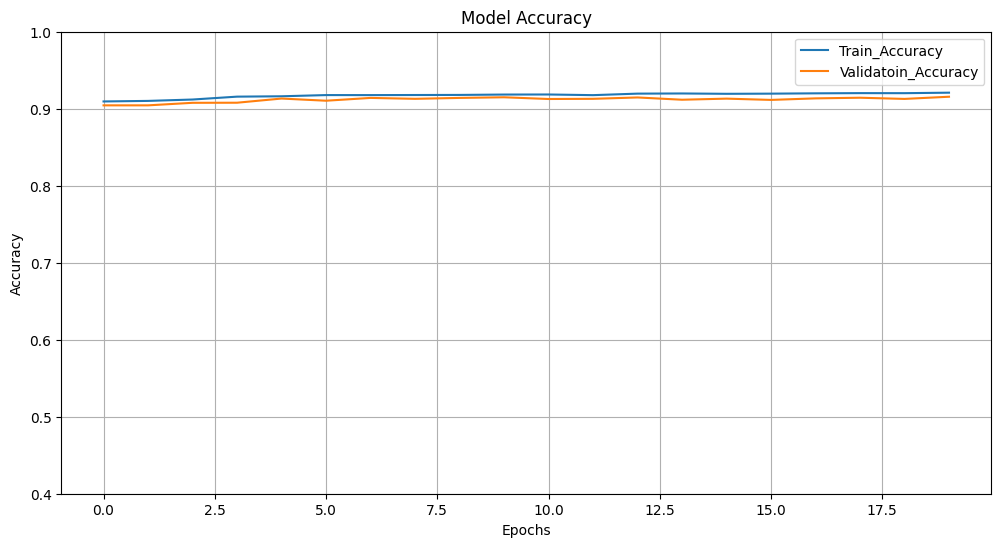

In [13]:
# Model Evaluation
# Plotting training and validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train_Accuracy', 'Validatoin_Accuracy'])
plt.show()

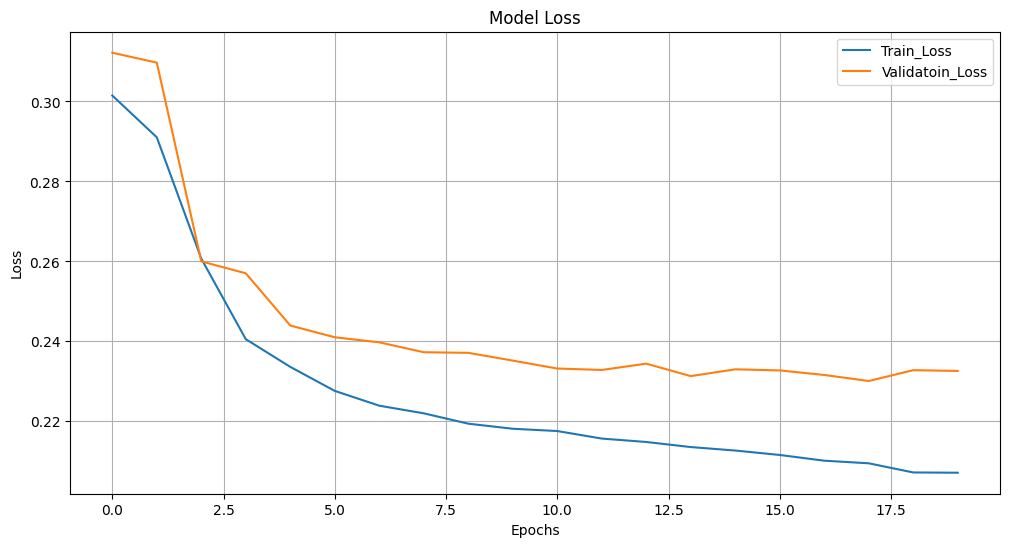

In [14]:
# Plotting loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train_Loss', 'Validatoin_Loss'])
plt.show()

In [ ]:
model.save('LSTM/Bidirectional_LSTM.keras')
print("----- <Model Saved in Keras Format> -----\n")